## 1. Prepare and Inspect the Dataset
Load the Kaggle dataset, inspect class folders, and verify image-label structure.

In [31]:
import kagglehub
import os
import matplotlib.pyplot as plt
from PIL import Image

path = kagglehub.dataset_download("ishans24/brain-tumor-dataset")
print("Dataset path:", path)

classes = sorted(os.listdir(path))
classes

Using Colab cache for faster access to the 'brain-tumor-dataset' dataset.
Dataset path: /kaggle/input/brain-tumor-dataset


['glioma', 'meningioma', 'no_tumor', 'pituitary']

### Class Balance
Check number of images per class to ensure balanced splits.

In [32]:
from collections import Counter

class_counts = {}

for label in classes:
    class_dir = os.path.join(path, label)
    class_counts[label] = len(os.listdir(class_dir))

class_counts

{'glioma': 3754, 'meningioma': 2343, 'no_tumor': 1757, 'pituitary': 2706}

## 2–3. Split Data and Define Dataset + Transforms

In [33]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from torchvision import transforms

image_paths, labels = [], []

for label in classes:
    for img in os.listdir(os.path.join(path, label)):
        image_paths.append(os.path.join(path, label, img))
        labels.append(label)

train_p, temp_p, train_l, temp_l = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

val_p, test_p, val_l, test_l = train_test_split(
    temp_p, temp_l, test_size=0.5, stratify=temp_l, random_state=42
)

label2id = {label: i for i, label in enumerate(classes)}
id2label = {i: label for label, i in label2id.items()}

img_size = 224

train_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class BrainTumorDataset(Dataset):
    def __init__(self, paths, labels, transform):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = Image.open(self.paths[idx]).convert("RGB")
        label = label2id[self.labels[idx]]
        return self.transform(image), label

train_ds = BrainTumorDataset(train_p, train_l, train_tf)
val_ds   = BrainTumorDataset(val_p, val_l, val_tf)
test_ds  = BrainTumorDataset(test_p, test_l, val_tf)

In [34]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.proj = nn.Conv2d(
            in_channels, embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

In [35]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

## 5. Vision Transformer Model
Full ViT model with CLS token and classification head.

In [36]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, num_classes, embed_dim, depth, num_heads, mlp_dim):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, 3, embed_dim)
        num_patches = (img_size // patch_size) ** 2

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, mlp_dim)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        return self.head(x[:, 0])

## 6. DataLoaders and Training Setup

In [37]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)
test_loader = DataLoader(test_ds, batch_size=16)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionTransformer(
    img_size=224,
    patch_size=16,
    num_classes=len(classes),
    embed_dim=768,
    depth=6,
    num_heads=8,
    mlp_dim=1024
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

## 7. Train and Validate

In [38]:
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

In [39]:
num_epochs = 5

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader)
    val_accuracy = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Accuracy: {val_accuracy:.4f}")

Epoch 1/5 - Train Loss: 1.2194 - Val Accuracy: 0.5388
Epoch 2/5 - Train Loss: 1.0609 - Val Accuracy: 0.5066
Epoch 3/5 - Train Loss: 1.0000 - Val Accuracy: 0.5824
Epoch 4/5 - Train Loss: 0.9508 - Val Accuracy: 0.6392
Epoch 5/5 - Train Loss: 0.8991 - Val Accuracy: 0.6695


## Evaluation Metrics
Accuracy and confusion matrix on the test set.

Test Accuracy: 0.6477272727272727


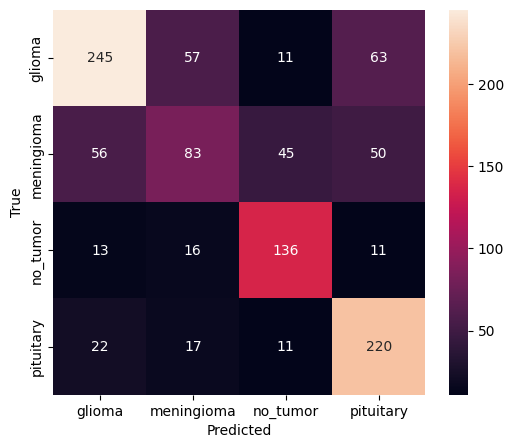

In [40]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print("Test Accuracy:", acc)

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Single Image Inference

Prediction: no_tumor


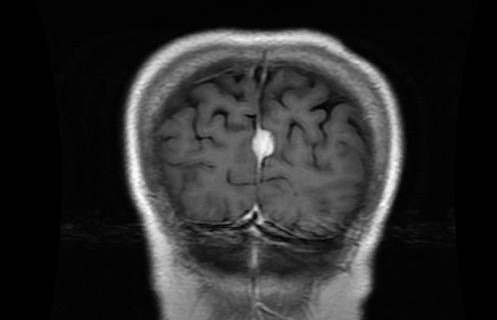

In [41]:
def predict_image(img_path, model):
    model.eval()
    image = Image.open(img_path).convert("RGB")
    x = val_tf(image).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(x).argmax(dim=1).item()

    return id2label[pred]

# Example
sample_image = test_p[0]
print("Prediction:", predict_image(sample_image, model))
Image.open(sample_image)